In [1]:
import pandas as pd
import numpy as np
from numpy.random import randn

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import statsmodels.formula.api as smf
from statsmodels.api import qqplot, add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.proportion import proportions_ztest

import graphviz
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import export_graphviz
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFE

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

import warnings
warnings.filterwarnings('ignore')

matplotlib.rc('font', family = 'NanumBarunGothic')
matplotlib.rc('axes', unicode_minus = False)

### 타겟변수
- Price : 중고차 가격(단위:천원)

### 설명변수
- Name : 자동차 브랜드, 모델
- Location : 영업점 위치
- Year : 모델 연식
- Kilometers_Driven : 차량 누적 주행거리(Km)
- Fuel_Type : 자동차 사용연료
- Transmission : 변속방식(Manual/Automatic)
- Owner_Type : 소유권한 여부
- Mileage : 표준주행거리(kmpl)
- Engine : 엔진배기량(cc)
- Power : 엔진최대출력(bhp)
- Seats : 좌석 수
- New_Price : 신차 가격

In [2]:
def classify_city_income(city_name):
    high_income = {
        "Mumbai": "High",
        "Delhi": "High",
        "Bangalore": "High",
        "Chennai": "High"}

    mid_income = {
        "Hyderabad": "Median",
        "Ahmedabad": "Median",
        "Pune": "Median",
        "Kolkata": "Median",
        "Coimbatore": "Median"}
    
    low_income = {
        "Jaipur": "Low",
        "Kochi": "Low"}
    
    city_name = city_name.strip()
    
    if city_name in high_income:
        return high_income[city_name]
    elif city_name in mid_income:
        return mid_income[city_name]
    elif city_name in low_income:
        return low_income[city_name]
    else:
        return np.nan
    
    
def classify_car_by_seats(seat_count):
    if seat_count == 2:
        return "Sports Car"
    elif seat_count == 4:
        return "Sedan"
    elif seat_count == 5:
        return "Standard Car"
    elif seat_count in (6, 7):
        return "SUV"
    else:
        return "Large Vehicle"
    
brand_categories = {
    'Audi': 'Luxury', 'BMW': 'Luxury', 'Mercedes-Benz': 'Luxury', 'Jaguar': 'Luxury', 'Porsche': 'Luxury', 'Bentley': 'Luxury', 'Lamborghini': 'Luxury',
    'Volvo': 'Premium', 'Land': 'Premium', 'Mini': 'Premium', 'Smart': 'Premium',
    'Toyota': 'Mainstream', 'Honda': 'Mainstream', 'Hyundai': 'Mainstream', 'Nissan': 'Mainstream', 'Volkswagen': 'Mainstream', 'Ford': 'Mainstream', 'Chevrolet': 'Mainstream',
    'Maruti': 'Economy', 'Tata': 'Economy', 'Mahindra': 'Economy', 'Datsun': 'Economy', 'Fiat': 'Economy', 'Renault': 'Economy', 'Skoda': 'Economy', 'Jeep': 'Economy', 'OpelCorsa': 'Economy',
    'ISUZU': 'Commercial/Utility', 'Force': 'Commercial/Utility', 'Hindustan': 'Commercial/Utility', 'Ambassador': 'Commercial/Utility', 'Mitsubishi': 'Mainstream'}

In [3]:
df = pd.read_csv("/home/piai/청년아카데미/01 실습파일/2. Big Data 분석/Car.csv")
df.shape

(7253, 13)

In [4]:
df['Engine'] = df['Engine'].replace(['null', '0 CC'], np.nan).astype(str).str.replace(' CC', '').astype(float)
df['Power'] = df['Power'].replace(['null bhp', '0 bhp'], np.nan).astype(str).str.replace(' bhp', '').astype(float)
df['Mileage'] = df['Mileage'].replace('null kmpl', np.nan).astype(str).str.replace(' kmpl', '').astype(str).str.replace(' km/kg', '').astype(float)

In [5]:
df.head()

,Name,Location,Price,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price
0,Maruti Wagon R LXI CNG,Mumbai,2682.68,2010,72000,CNG,Manual,First,26.60,998.0,58.16,5.0,NaN
1,Hyundai Creta 1.6 CRDi SX Option,Pune,19162.00,2015,41000,Diesel,Manual,First,19.67,1582.0,126.20,5.0,NaN
2,Honda Jazz V,Chennai,6898.32,2011,46000,Petrol,Manual,First,18.20,1199.0,88.70,5.0,8.61 Lakh
3,Maruti Ertiga VDI,Chennai,9197.76,2012,87000,Diesel,Manual,First,20.77,1248.0,88.76,7.0,NaN
4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,27194.71,2013,40670,Diesel,Automatic,Second,15.20,1968.0,140.80,5.0,NaN


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7253 entries, 0 to 7252
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Name               7253 non-null   object 
 1   Location           7253 non-null   object 
 2   Price              6200 non-null   float64
 3   Year               7253 non-null   int64  
 4   Kilometers_Driven  7253 non-null   int64  
 5   Fuel_Type          7253 non-null   object 
 6   Transmission       7253 non-null   object 
 7   Owner_Type         7253 non-null   object 
 8   Mileage            7251 non-null   float64
 9   Engine             7207 non-null   float64
 10  Power              7078 non-null   float64
 11  Seats              7200 non-null   float64
 12  New_Price          1006 non-null   object 
dtypes: float64(5), int64(2), object(6)
memory usage: 736.8+ KB


In [7]:
df.describe()

,Price,Year,Kilometers_Driven,Mileage,Engine,Power,Seats
count,6200.000000,7253.000000,7.253000e+03,7251.000000,7207.000000,7078.000000,7200.000000
mean,14912.514750,2013.365366,5.869906e+04,18.141580,1616.573470,112.765214,5.279722
std,17674.318464,3.254421,8.442772e+04,4.562197,595.285137,53.493553,0.811660
min,7.080000,1996.000000,1.710000e+02,0.000000,72.000000,34.200000,0.000000
25%,5365.360000,2011.000000,3.400000e+04,15.170000,1198.000000,75.000000,5.000000
50%,8814.520000,2014.000000,5.341600e+04,18.160000,1493.000000,94.000000,5.000000
75%,15869.972500,2016.000000,7.300000e+04,21.100000,1968.000000,138.100000,5.000000
max,245273.600000,2019.000000,6.500000e+06,33.540000,5998.000000,616.000000,10.000000


In [8]:
df.describe(include = 'object')

,Name,Location,Fuel_Type,Transmission,Owner_Type,New_Price
count,7253,7253,7253,7253,7253,1006
unique,2041,11,5,2,4,625
top,Mahindra XUV500 W8 2WD,Mumbai,Diesel,Manual,First,63.71 Lakh
freq,55,949,3852,5204,5952,6


> 약 7300개의 뎅터 행개수의 대다수가 널값인 New_Price 열은 지워주었습니다

In [9]:
df.drop(labels = 'New_Price', axis = 1, inplace = True)

> Engine과 Power 값의 경우 회귀모델을 설계하여 널값을 제외한 값들로 학습시키고 비어있는 값들을 에측하여 넣어주었습니다. 200개정도의 널값이 있었기에 과적합의 우려가 적을것이라 판단했습니다.

In [10]:
missing_engine_indices = df[df['Engine'].isnull() | (df['Engine'] == 0)].index

imputer = SimpleImputer(strategy='mean')
df[['Engine', 'Power', 'Mileage']] = imputer.fit_transform(df[['Engine', 'Power', 'Mileage']])

engine_data = df[['Engine', 'Power', 'Year', 'Kilometers_Driven', 'Fuel_Type', 'Transmission', 'Owner_Type', 'Mileage']]
engine_data = pd.get_dummies(engine_data, columns=['Fuel_Type', 'Transmission', 'Owner_Type'], drop_first=True)

train_data = engine_data[engine_data['Engine'].notnull() | (engine_data['Engine'] == 0)]
predict_data = engine_data.loc[missing_engine_indices]

X_train = train_data.drop('Engine', axis=1)
y_train = train_data['Engine']
X_predict = predict_data.drop('Engine', axis=1)

if not X_predict.empty:
    engine_model = RandomForestRegressor(n_estimators=100, random_state=42)
    engine_model.fit(X_train, y_train)

    predicted_engines = engine_model.predict(X_predict)
    df.loc[missing_engine_indices, 'Engine'] = predicted_engines

In [11]:
missing_power_indices = df[df['Power'].isnull() | (df['Power'] == 0)].index

power_data = df[['Power', 'Engine', 'Year', 'Kilometers_Driven', 'Fuel_Type', 'Transmission', 'Owner_Type', 'Mileage']]
power_data = pd.get_dummies(power_data, columns=['Fuel_Type', 'Transmission', 'Owner_Type'], drop_first=True)

train_data = power_data[power_data['Power'].notnull()| (engine_data['Power'] == 0)]
predict_data = power_data.loc[missing_power_indices]

X_train = train_data.drop('Power', axis=1)
y_train = train_data['Power']
X_predict = predict_data.drop('Power', axis=1)

if not X_predict.empty:
    power_model = RandomForestRegressor(n_estimators=100, random_state=42)
    power_model.fit(X_train, y_train)

    predicted_powers = power_model.predict(X_predict)
    df.loc[missing_power_indices, 'Power'] = predicted_powersMaruti

In [12]:
missing_mileage_indices = df[df['Mileage'].isnull() | (df['Mileage'] == 0)].index

mileage_data = df[['Power', 'Engine', 'Year', 'Kilometers_Driven', 'Fuel_Type', 'Transmission', 'Owner_Type', 'Mileage']]
mileage_data = pd.get_dummies(mileage_data, columns=['Fuel_Type', 'Transmission', 'Owner_Type'], drop_first=True)

train_data = mileage_data[mileage_data['Mileage'].notnull() | (engine_data['Mileage'] == 0)]
predict_data = mileage_data.loc[missing_mileage_indices]

X_train = train_data.drop('Mileage', axis=1)
y_train = train_data['Mileage']
X_predict = predict_data.drop('Mileage', axis=1)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

if not X_predict.empty:
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }

    grid_search = GridSearchCV(estimator=RandomForestRegressor(random_state=42), param_grid=param_grid, cv=5, n_jobs=-1)
    grid_search.fit(X_train, y_train)

    best_params = grid_search.best_params_
    print("Best Parameters:", best_params)

    best_model = grid_search.best_estimator_
    predicted_mileages = best_model.predict(X_predict)

    df.loc[missing_mileage_indices, 'Mileage'] = predicted_mileages

Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}


In [13]:
val_predictions = best_model.predict(X_val)
print("Validation MAE:", mean_absolute_error(y_val, val_predictions))
print("Validation MSE:", mean_squared_error(y_val, val_predictions))
print("Validation RMSE:", np.sqrt(mean_squared_error(y_val, val_predictions)))
print("Validation R^2 Score:", r2_score(y_val, val_predictions))

predicted_mileages = best_model.predict(X_predict)
df.loc[missing_mileage_indices, 'Mileage'] = predicted_mileages

Validation MAE: 0.7542989483438974
Validation MSE: 2.2220484966652045
Validation RMSE: 1.4906537145377543
Validation R^2 Score: 0.8867211765970708


In [14]:
# mean_mileage = df['Mileage'].mean()
# df_mean_filled = df.copy()
# df_mean_filled.loc[missing_mileage_indices, 'Mileage'] = mean_mileage

# mileage_data_mean_filled = df_mean_filled[['Power', 'Engine', 'Year', 'Kilometers_Driven', 'Fuel_Type', 'Transmission', 'Owner_Type', 'Mileage']]
# mileage_data_mean_filled = pd.get_dummies(mileage_data_mean_filled, columns=['Fuel_Type', 'Transmission', 'Owner_Type'], drop_first=True)

# train_data_mean_filled = mileage_data_mean_filled[mileage_data_mean_filled['Mileage'].notnull()]
# predict_data_mean_filled = mileage_data_mean_filled.loc[missing_mileage_indices]

# X_train_mean_filled = train_data_mean_filled.drop('Mileage', axis=1)
# y_train_mean_filled = train_data_mean_filled['Mileage']
# X_predict_mean_filled = predict_data_mean_filled.drop('Mileage', axis=1)

# X_train_mean_filled, X_val_mean_filled, y_train_mean_filled, y_val_mean_filled = train_test_split(X_train_mean_filled, y_train_mean_filled, test_size=0.2, random_state=42)

# print("Validation MAE (Mean):", mean_absolute_error(y_val_mean_filled, df_mean_filled))
# print("Validation MSE (Mean):", mean_squared_error(y_val_mean_filled, df_mean_filled))
# print("Validation RMSE (Mean):", np.sqrt(mean_squared_error(y_val_mean_filled, df_mean_filled)))
# print("Validation R^2 Score (Mean):", r2_score(y_val_mean_filled, df_mean_filled))


In [15]:
df['Year'] = 2024 - df['Year']

In [16]:
df['Location_income'] = df['Location'].apply(classify_city_income)
df['Car_cate'] = df['Seats'].apply(classify_car_by_seats)
df['Brand'] = df['Name'].apply(lambda x :x.split()[0])

In [17]:
df['Brand_Category'] = df['Brand'].str.split().str[0].map(brand_categories).fillna('Unknown')

> Seats 값의 경우 7인 모델하나를 제외하고 나머지 모델은 전부 5인승이기에 서칭한 데이터를 기반으로 값을 넣어주었습니다.

In [18]:
condition = (df['Seats'].isnull() & (df['Name'] == 'Mahindra TUV 300 P4'))
df.loc[condition, 'Seats'] = 7

condition1 = (df['Seats'].isnull() & (df['Name'] != 'Mahindra TUV 300 P4'))
df.loc[condition1, 'Seats'] = 5

df.loc[3999, 'Seats'] = 5

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7253 entries, 0 to 7252
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Name               7253 non-null   object 
 1   Location           7253 non-null   object 
 2   Price              6200 non-null   float64
 3   Year               7253 non-null   int64  
 4   Kilometers_Driven  7253 non-null   int64  
 5   Fuel_Type          7253 non-null   object 
 6   Transmission       7253 non-null   object 
 7   Owner_Type         7253 non-null   object 
 8   Mileage            7253 non-null   float64
 9   Engine             7253 non-null   float64
 10  Power              7253 non-null   float64
 11  Seats              7253 non-null   float64
 12  Location_income    7253 non-null   object 
 13  Car_cate           7253 non-null   object 
 14  Brand              7253 non-null   object 
 15  Brand_Category     7253 non-null   object 
dtypes: float64(5), int64(2),

In [20]:
df.describe()

,Price,Year,Kilometers_Driven,Mileage,Engine,Power,Seats
count,6200.000000,7253.000000,7.253000e+03,7253.000000,7253.000000,7253.000000,7253.000000
mean,14912.514750,10.634634,5.869906e+04,18.189127,1616.238304,112.765214,5.278643
std,17674.318464,3.254421,8.442772e+04,4.410405,593.439536,52.844178,0.806915
min,7.080000,5.000000,1.710000e+02,0.063000,72.000000,34.200000,2.000000
25%,5365.360000,8.000000,3.400000e+04,15.200000,1198.000000,77.000000,5.000000
50%,8814.520000,10.000000,5.341600e+04,18.160000,1493.000000,98.600000,5.000000
75%,15869.972500,13.000000,7.300000e+04,21.100000,1968.000000,138.030000,5.000000
max,245273.600000,28.000000,6.500000e+06,33.540000,5998.000000,616.000000,10.000000


In [21]:
df.describe(include = 'object')

,Name,Location,Fuel_Type,Transmission,Owner_Type,Location_income,Car_cate,Brand,Brand_Category
count,7253,7253,7253,7253,7253,7253,7253,7253,7253
unique,2041,11,5,2,4,3,5,32,5
top,Mahindra XUV500 W8 2WD,Mumbai,Diesel,Manual,First,Median,Standard Car,Maruti,Mainstream
freq,55,949,3852,5204,5952,3342,6047,1444,3619


Text(0.5, 1.0, 'Power')

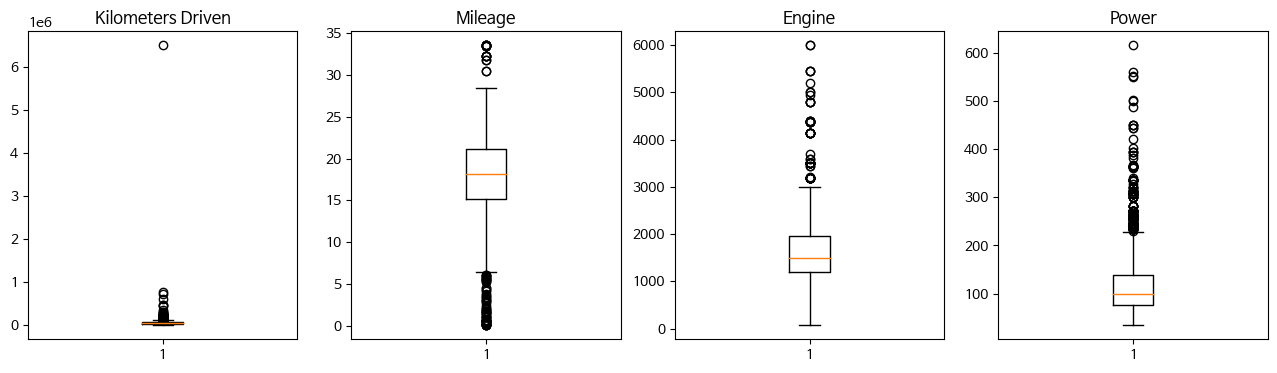

In [22]:
fig, ax = plt.subplots(1,4, figsize=(16,4))

ax[0].boxplot(df.Kilometers_Driven)
ax[0].set_title("Kilometers Driven")

ax[1].boxplot(df.Mileage)
ax[1].set_title("Mileage")

ax[2].boxplot(df.Engine)
ax[2].set_title("Engine")

ax[3].boxplot(df.Power)
ax[3].set_title("Power")

> 상용차 기준 Kilometers_Driven의 값이 300,000이상인 데이터는 이상치로 판단하여 제거하였습니다.

In [23]:
df.drop(df[df['Kilometers_Driven'] > 300000].index, inplace=True)

> 엔진cc는 고급형이 아닌차가 수치가 높게 나오는 경우 이상치로 간주하여 제거하였습니다. 너무 낮은 값도 제거하였습니다.

In [24]:
df = df.drop(df[(df['Engine'] > 4000) & (~df['Brand_Category'].isin(['Luxury', 'Premium']))].index)
df = df.drop(df[df['Engine'] < 800].index)

> 엔진cc는 고급형이 아닌차가 수치가 높게 나오는 경우 이상치로 간주하여 제거하였습니다. 너무 낮은 값도 제거하였습니다.

In [25]:
df.drop(df[(df['Power'] > 400) & (~df['Brand_Category'].isin(['Luxury', 'Premium']))].index)
df.drop(df[(df['Power'] < 60)].index)

,Name,Location,Price,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Location_income,Car_cate,Brand,Brand_Category
1,Hyundai Creta 1.6 CRDi SX Option,Pune,19162.00,9,41000,Diesel,Manual,First,19.67,1582.0,126.20,5.0,Median,Standard Car,Hyundai,Mainstream
2,Honda Jazz V,Chennai,6898.32,13,46000,Petrol,Manual,First,18.20,1199.0,88.70,5.0,High,Standard Car,Honda,Mainstream
3,Maruti Ertiga VDI,Chennai,9197.76,12,87000,Diesel,Manual,First,20.77,1248.0,88.76,7.0,High,SUV,Maruti,Economy
4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,27194.71,11,40670,Diesel,Automatic,Second,15.20,1968.0,140.80,5.0,Median,Standard Car,Audi,Luxury
6,Nissan Micra Diesel XV,Jaipur,5365.36,11,86999,Diesel,Manual,First,23.08,1461.0,63.10,5.0,Low,Standard Car,Nissan,Mainstream
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7248,Volkswagen Vento Diesel Trendline,Hyderabad,NaN,13,89411,Diesel,Manual,First,20.54,1598.0,103.60,5.0,Median,Standard Car,Volkswagen,Mainstream
7249,Volkswagen Polo GT TSI,Mumbai,NaN,9,59000,Petrol,Automatic,First,17.21,1197.0,103.60,5.0,High,Standard Car,Volkswagen,Mainstream
7250,Nissan Micra Diesel XV,Kolkata,NaN,12,28000,Diesel,Manual,First,23.08,1461.0,63.10,5.0,Median,Standard Car,Nissan,Mainstream
7251,Volkswagen Polo GT TSI,Pune,NaN,11,52262,Petrol,Automatic,Third,17.20,1197.0,103.60,5.0,Median,Standard Car,Volkswagen,Mainstream


columns_to_encode = ['Transmission', 'Owner_Type', 'Fuel_Type', 'Owner_Type', 'Location_income','Car_cate','Brand_Category']

df = pd.get_dummies(df, columns=columns_to_encode)

<Axes: xlabel='Kilometers_Driven', ylabel='Price'>

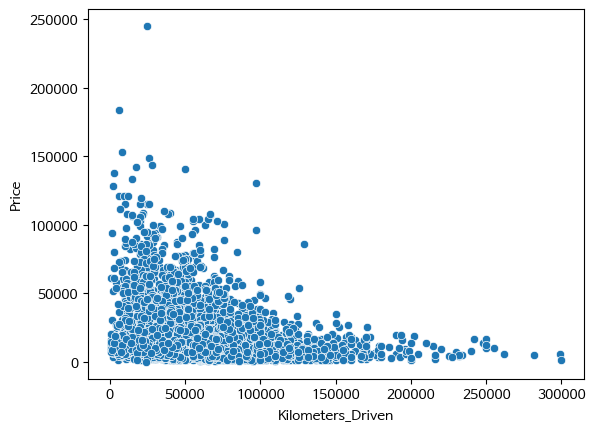

In [26]:
sns.scatterplot(x=df.Kilometers_Driven, y=df.Price)

<Axes: xlabel='Year', ylabel='Price'>

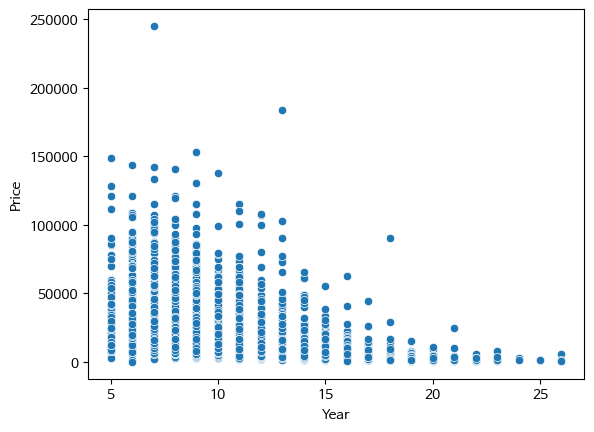

In [27]:
sns.scatterplot(x=df.Year, y=df.Price)

<Axes: xlabel='Mileage', ylabel='Price'>

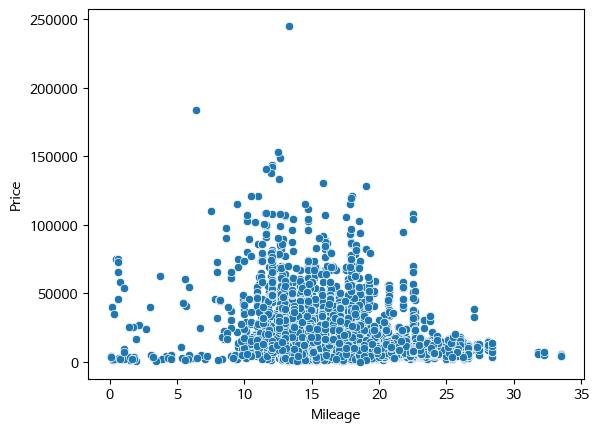

In [28]:
sns.scatterplot(x=df.Mileage, y=df.Price)

<Axes: xlabel='Engine', ylabel='Price'>

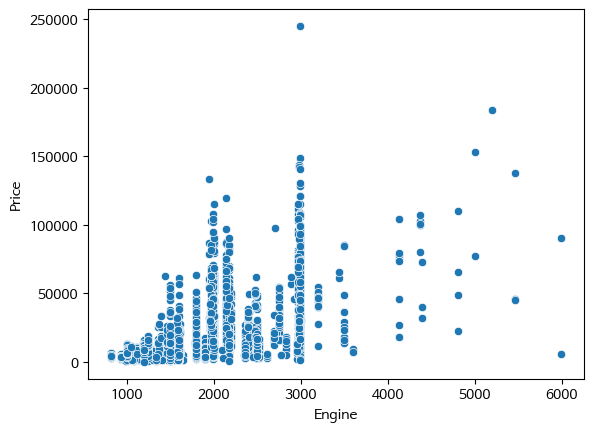

In [29]:
sns.scatterplot(x=df.Engine, y=df.Price)

<Axes: xlabel='Power', ylabel='Price'>

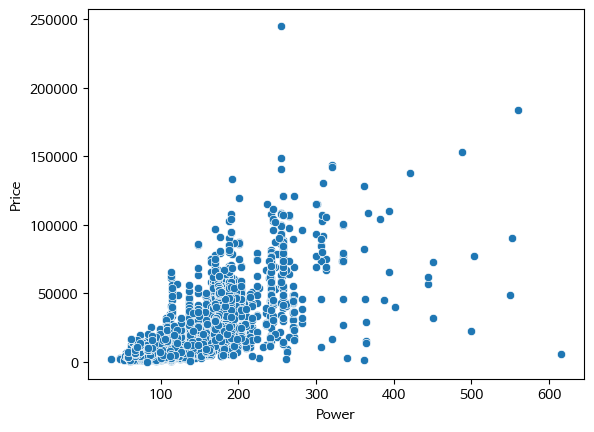

In [30]:
sns.scatterplot(x=df.Power, y=df.Price)

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7003 entries, 0 to 7252
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Name               7003 non-null   object 
 1   Location           7003 non-null   object 
 2   Price              5992 non-null   float64
 3   Year               7003 non-null   int64  
 4   Kilometers_Driven  7003 non-null   int64  
 5   Fuel_Type          7003 non-null   object 
 6   Transmission       7003 non-null   object 
 7   Owner_Type         7003 non-null   object 
 8   Mileage            7003 non-null   float64
 9   Engine             7003 non-null   float64
 10  Power              7003 non-null   float64
 11  Seats              7003 non-null   float64
 12  Location_income    7003 non-null   object 
 13  Car_cate           7003 non-null   object 
 14  Brand              7003 non-null   object 
 15  Brand_Category     7003 non-null   object 
dtypes: float64(5), int64(2),

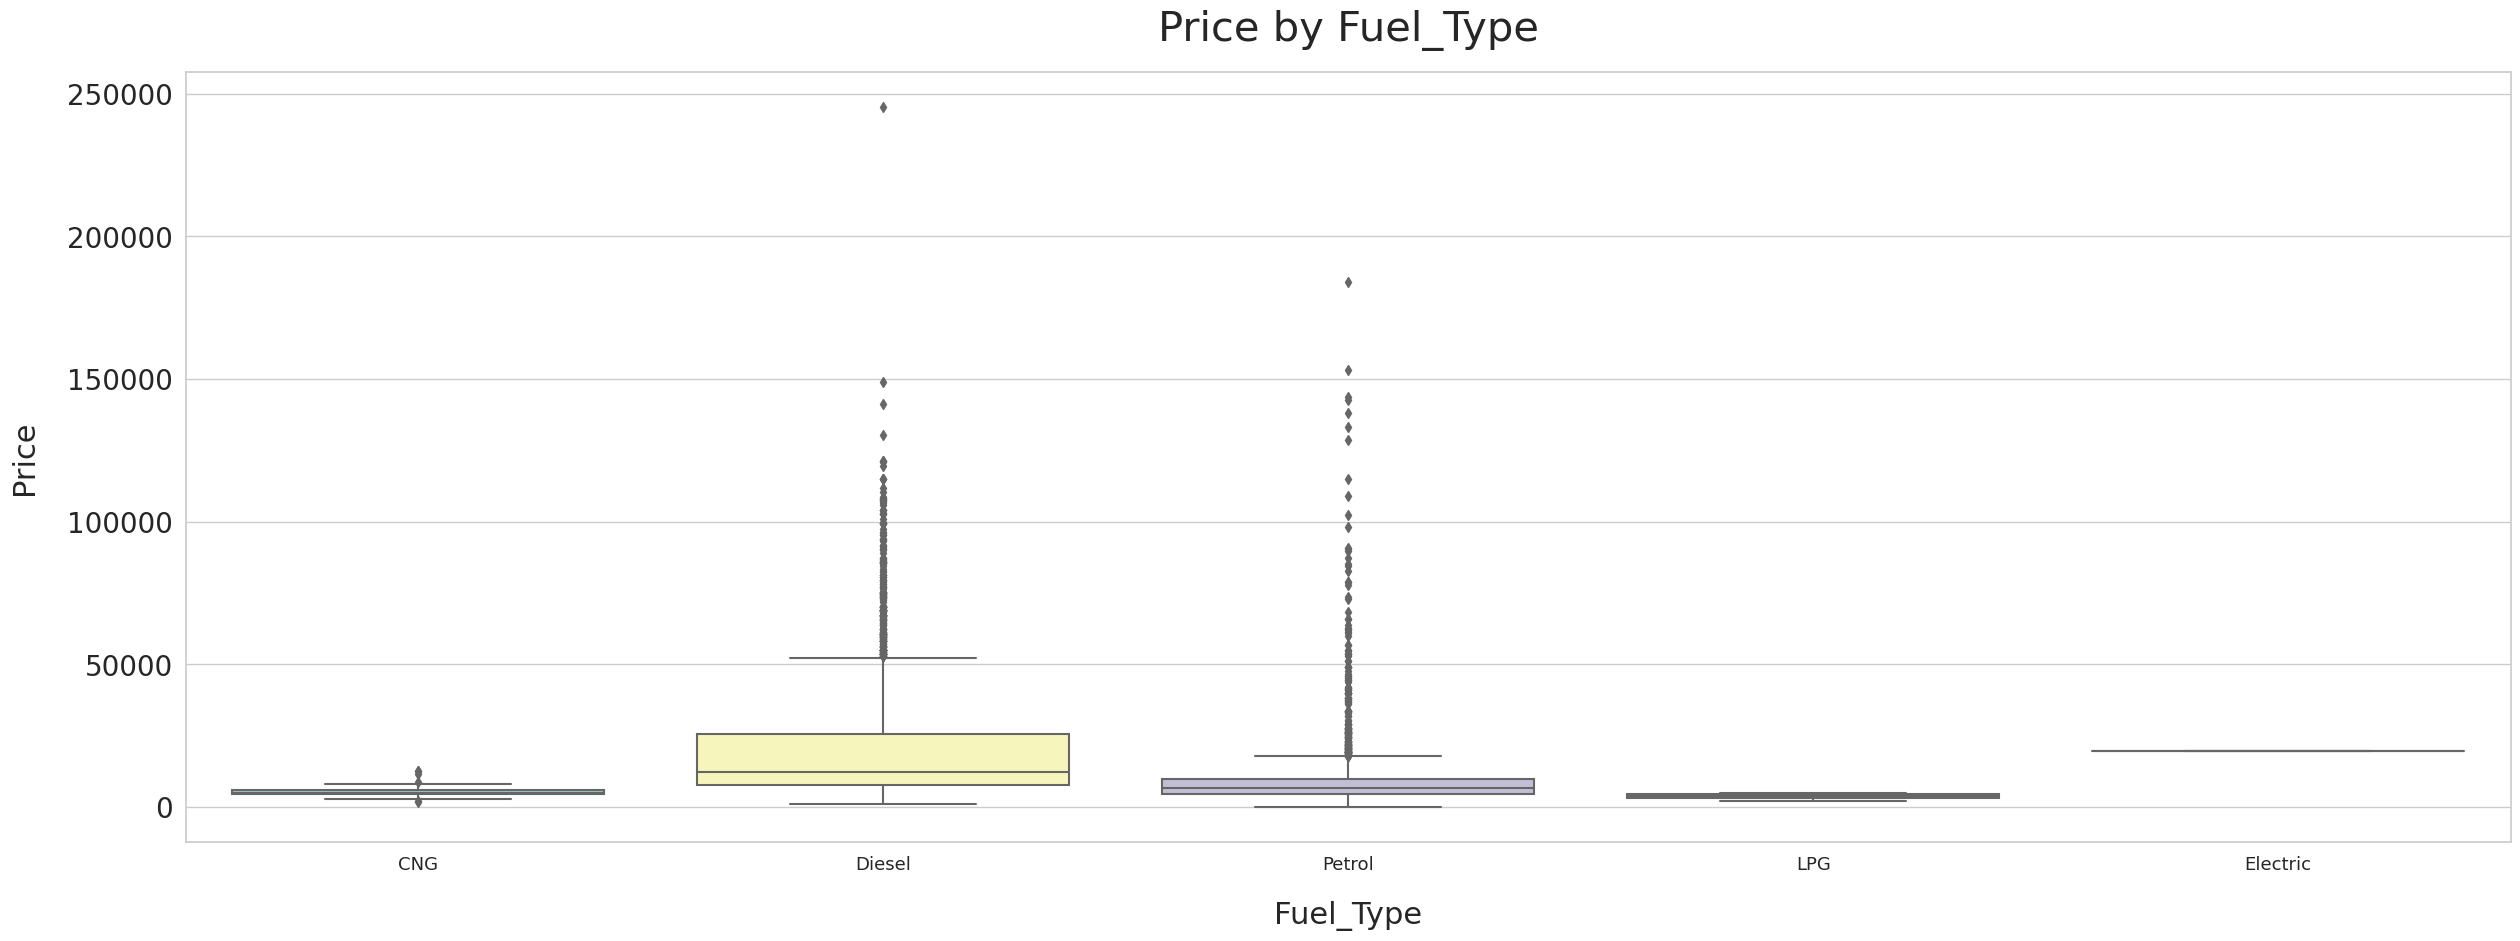

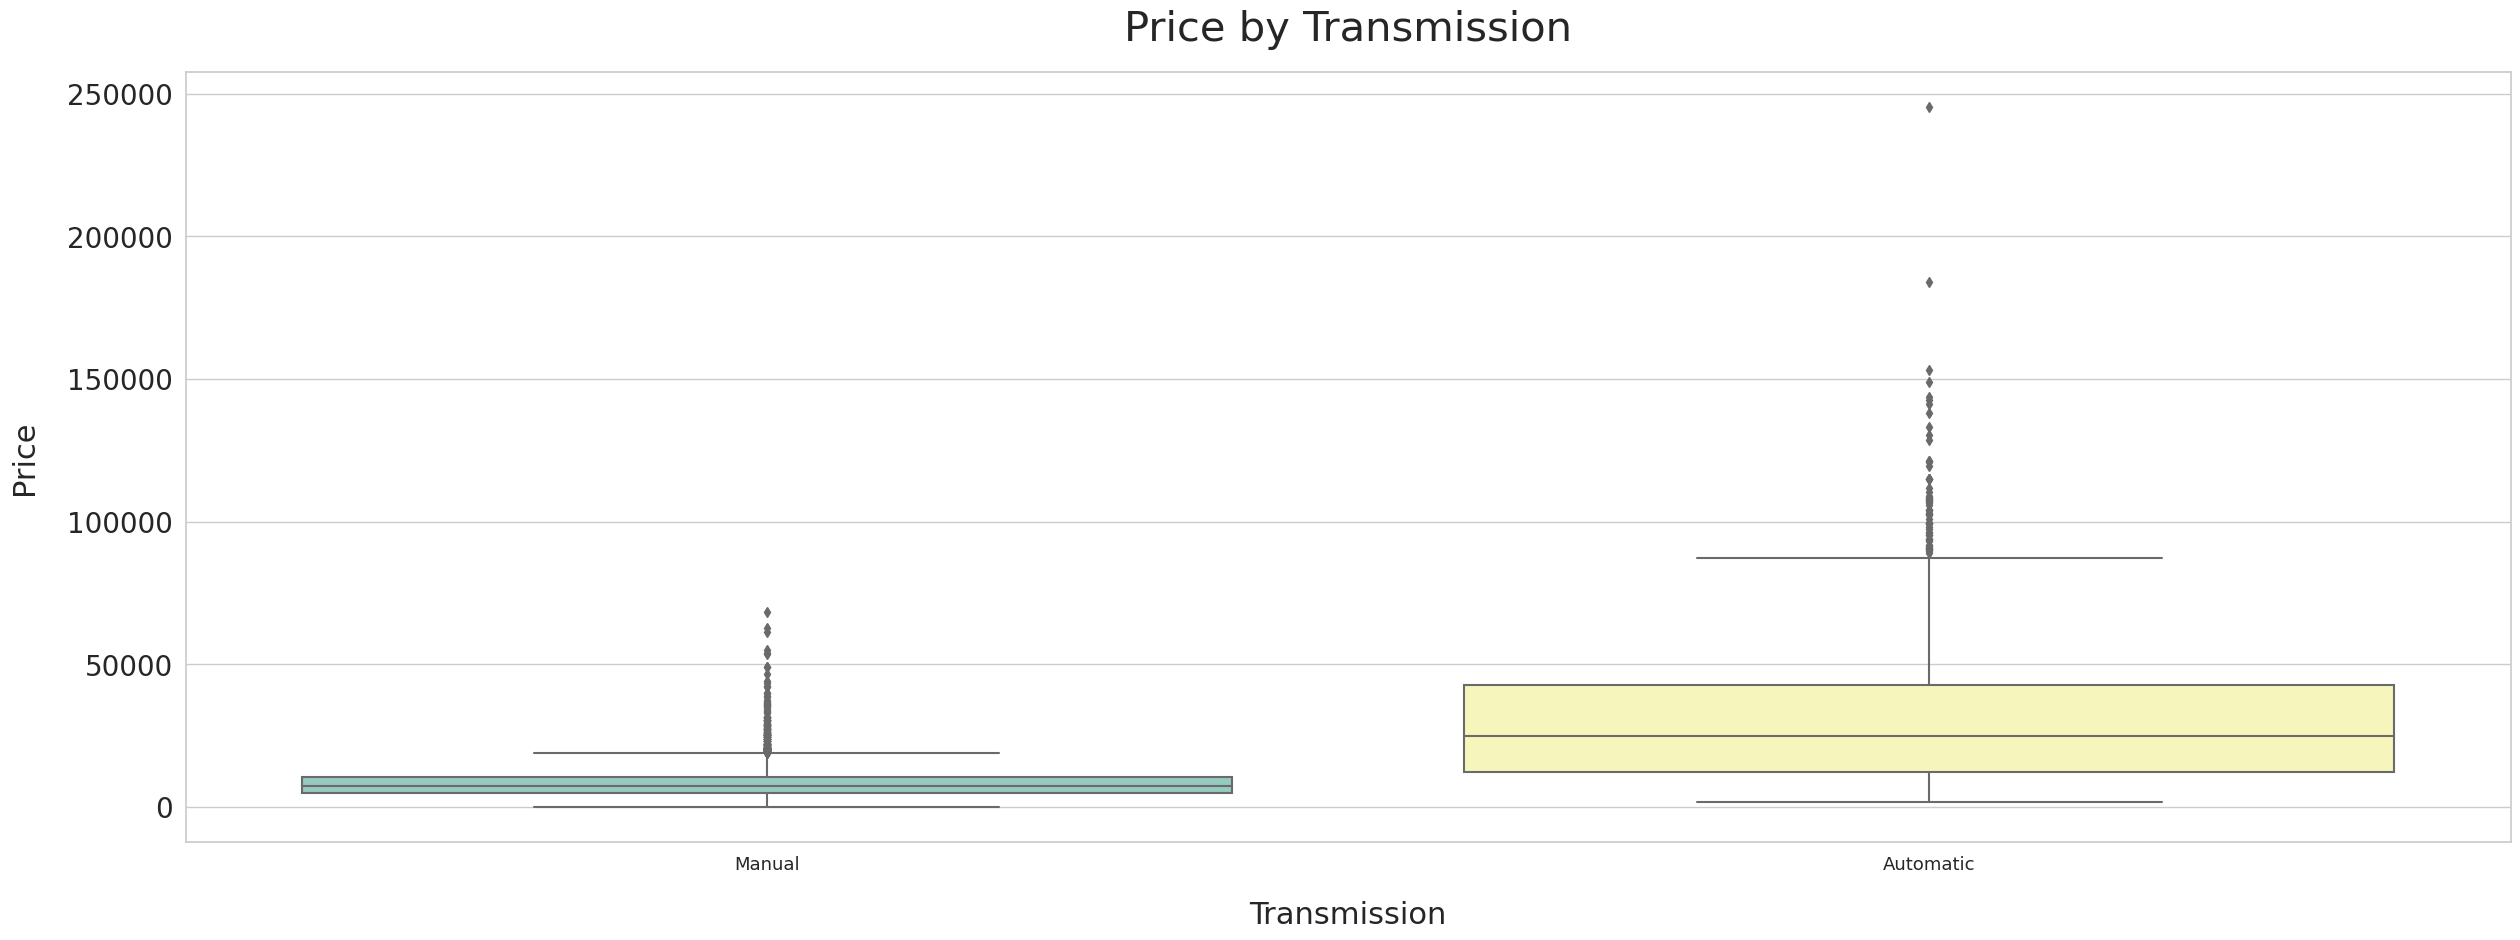

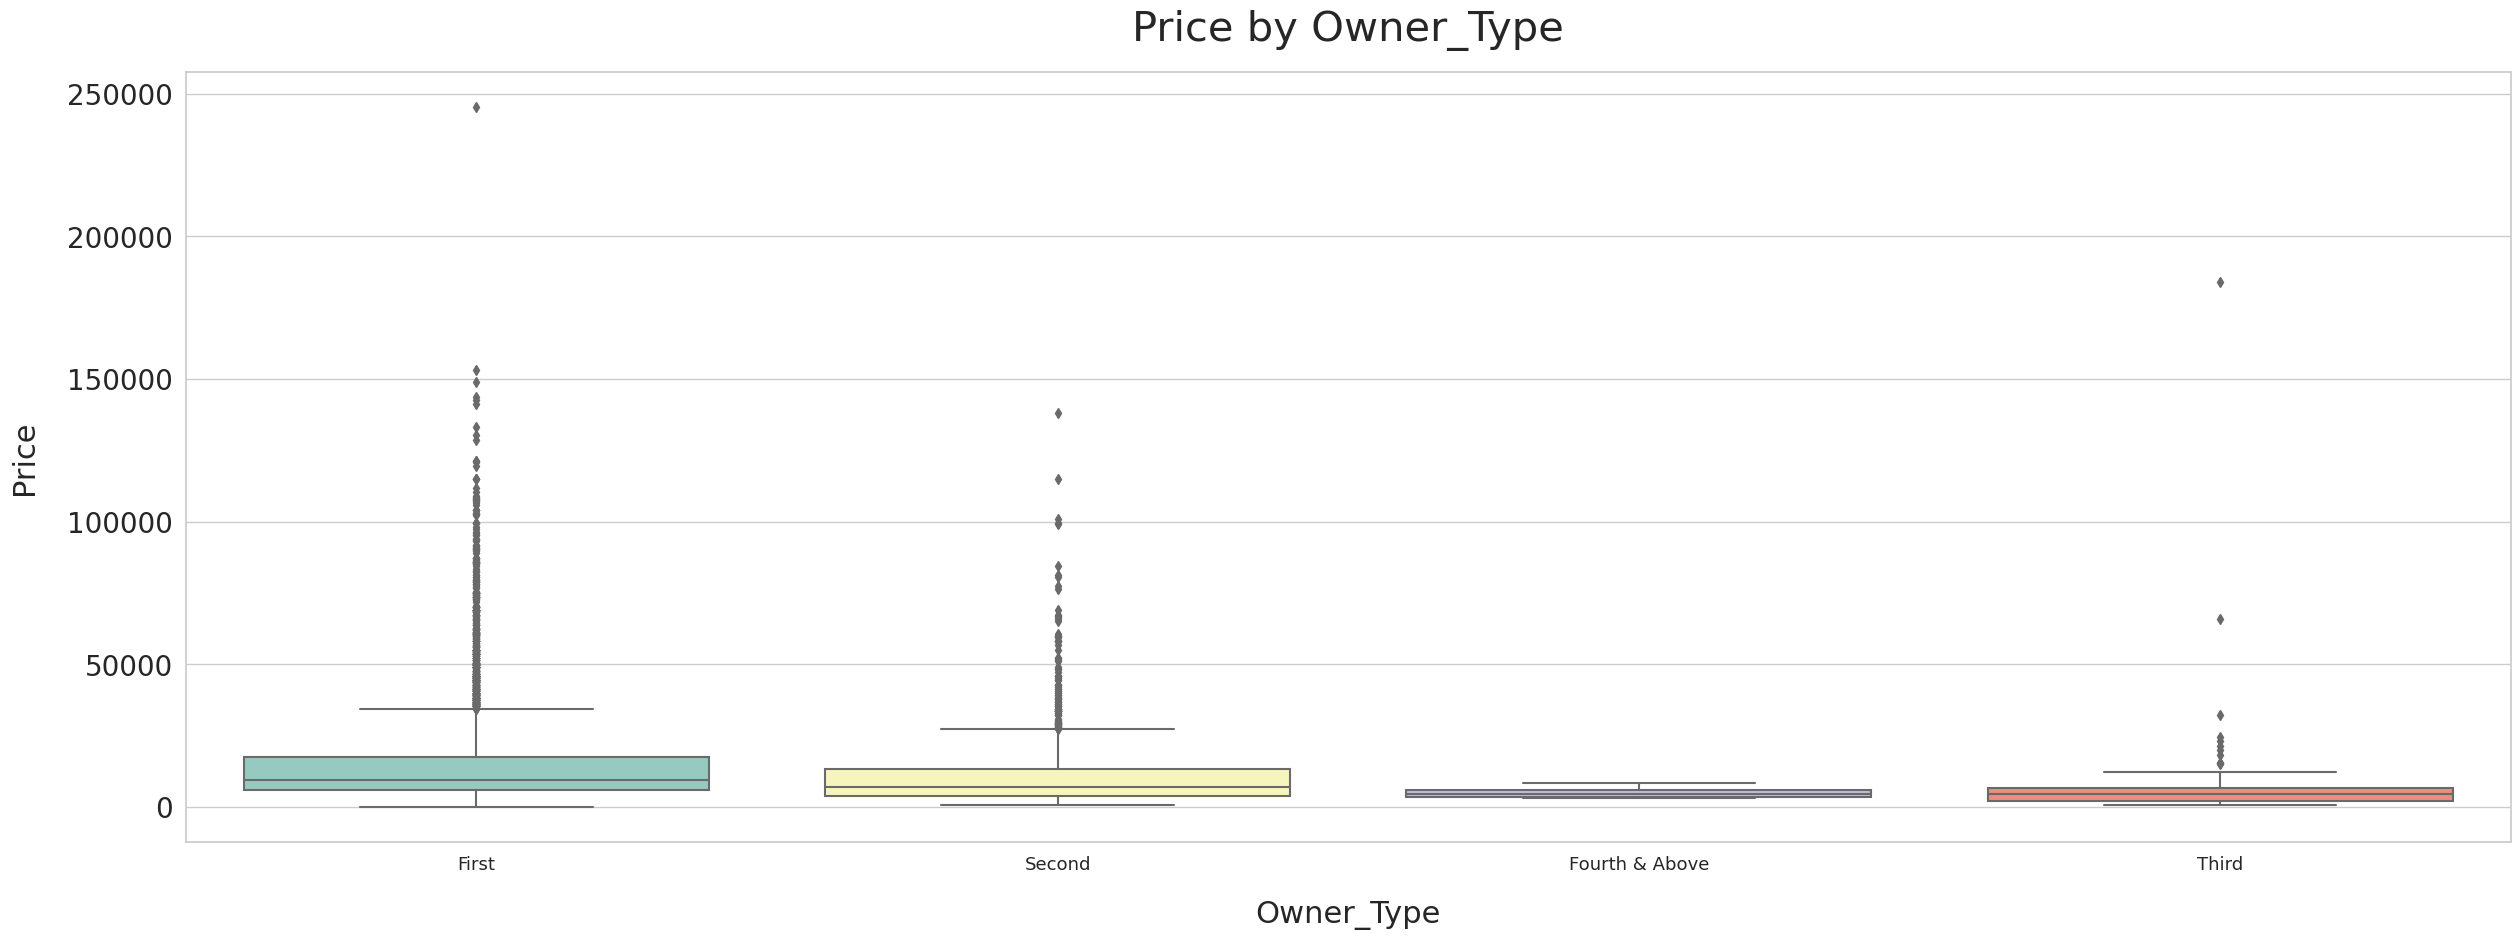

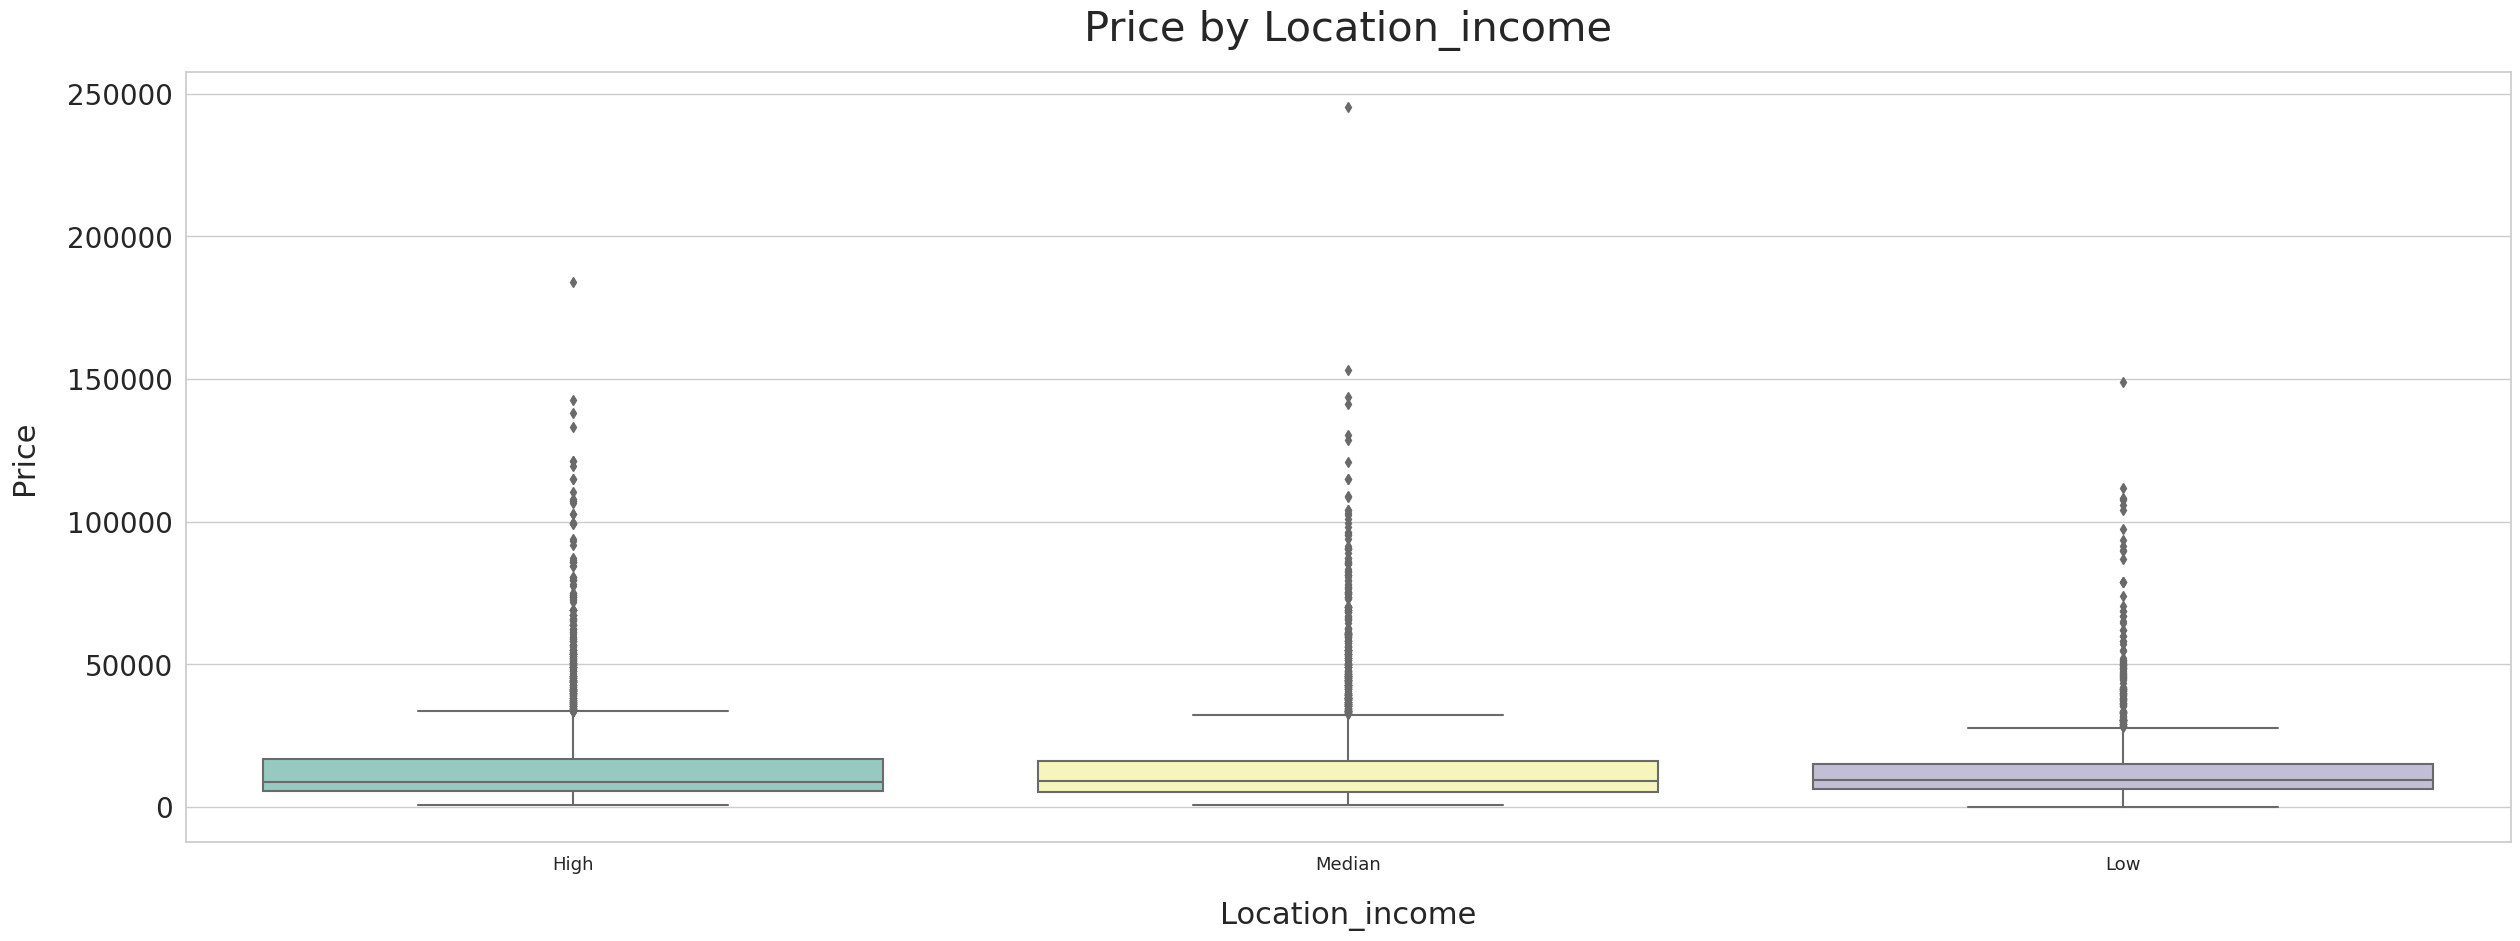

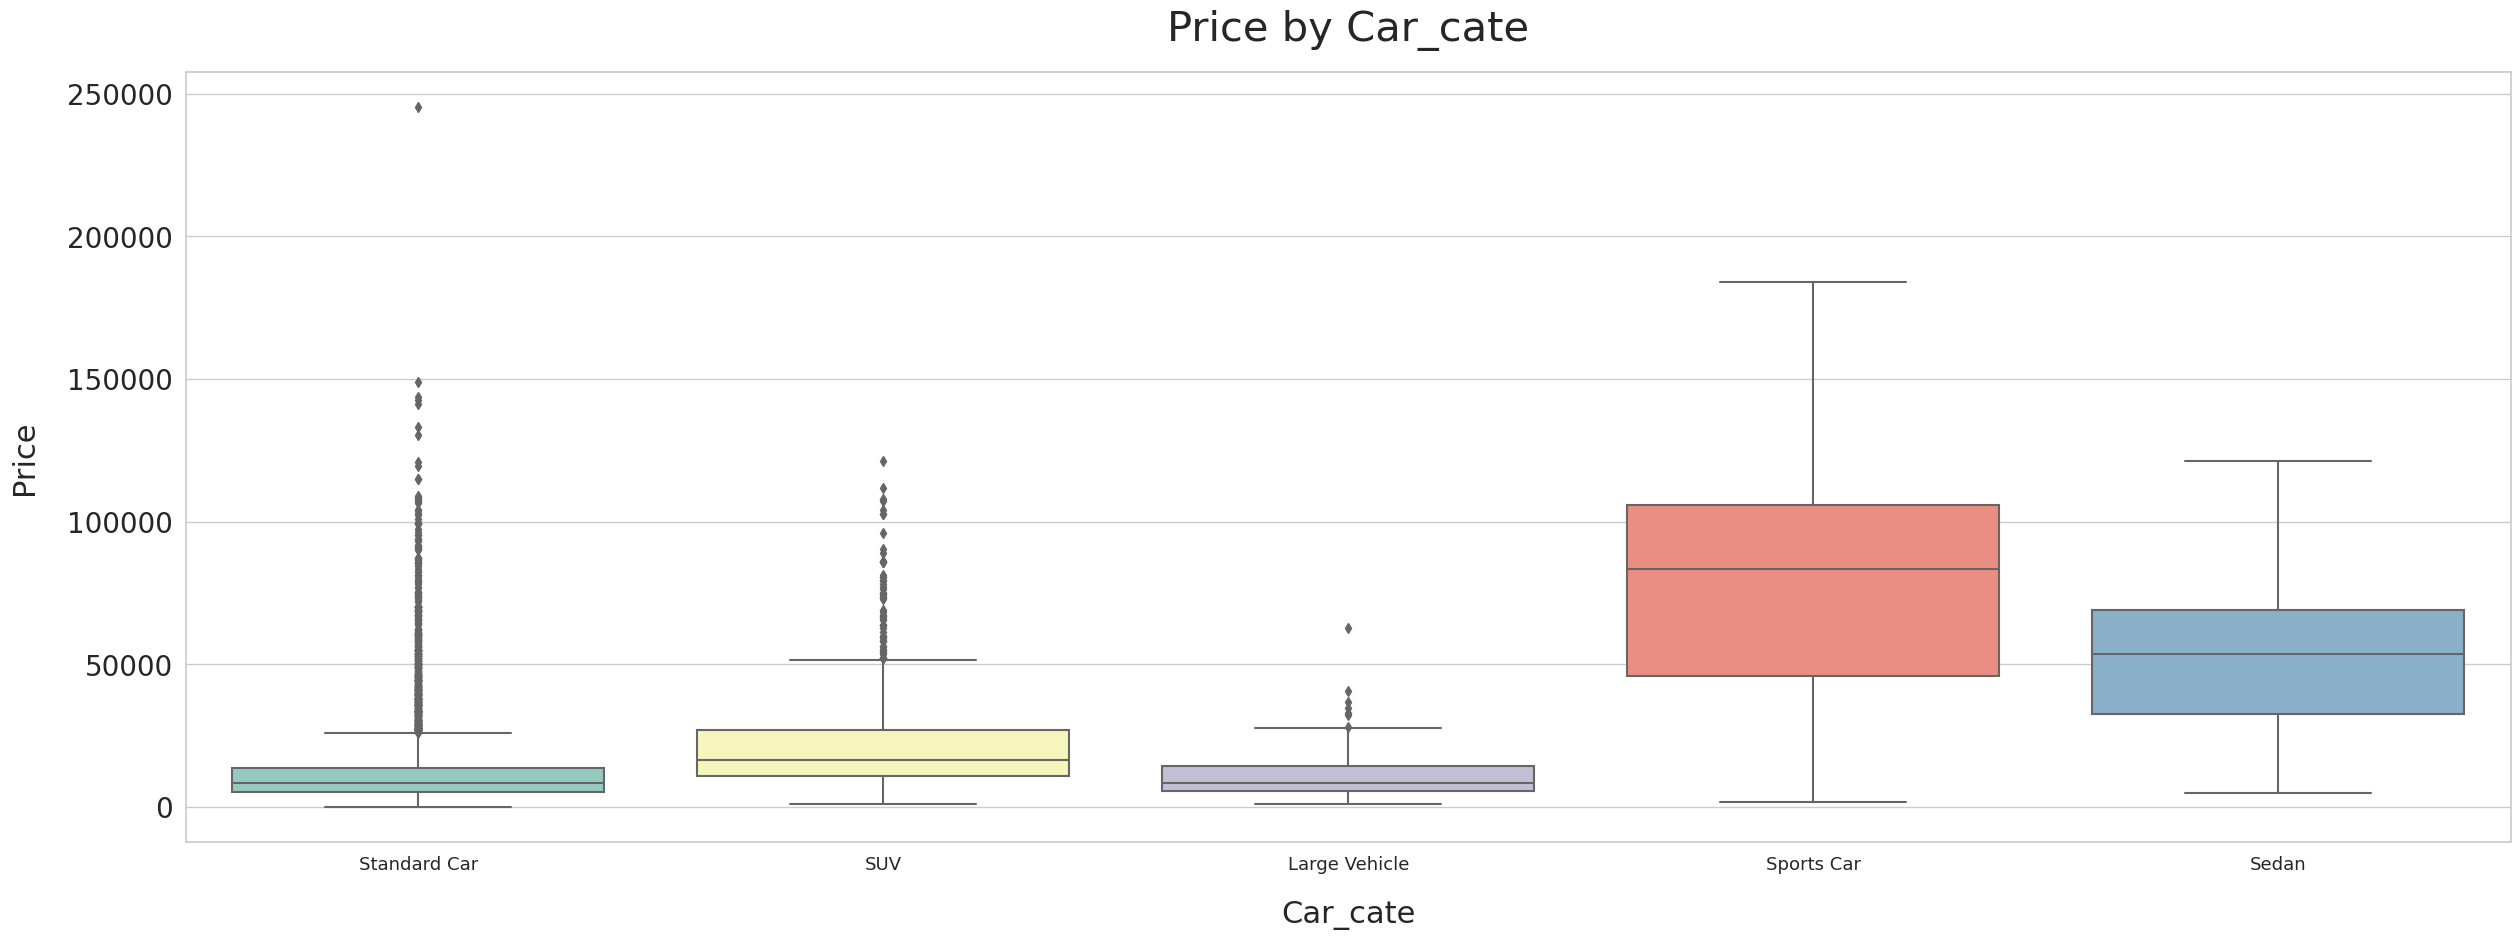

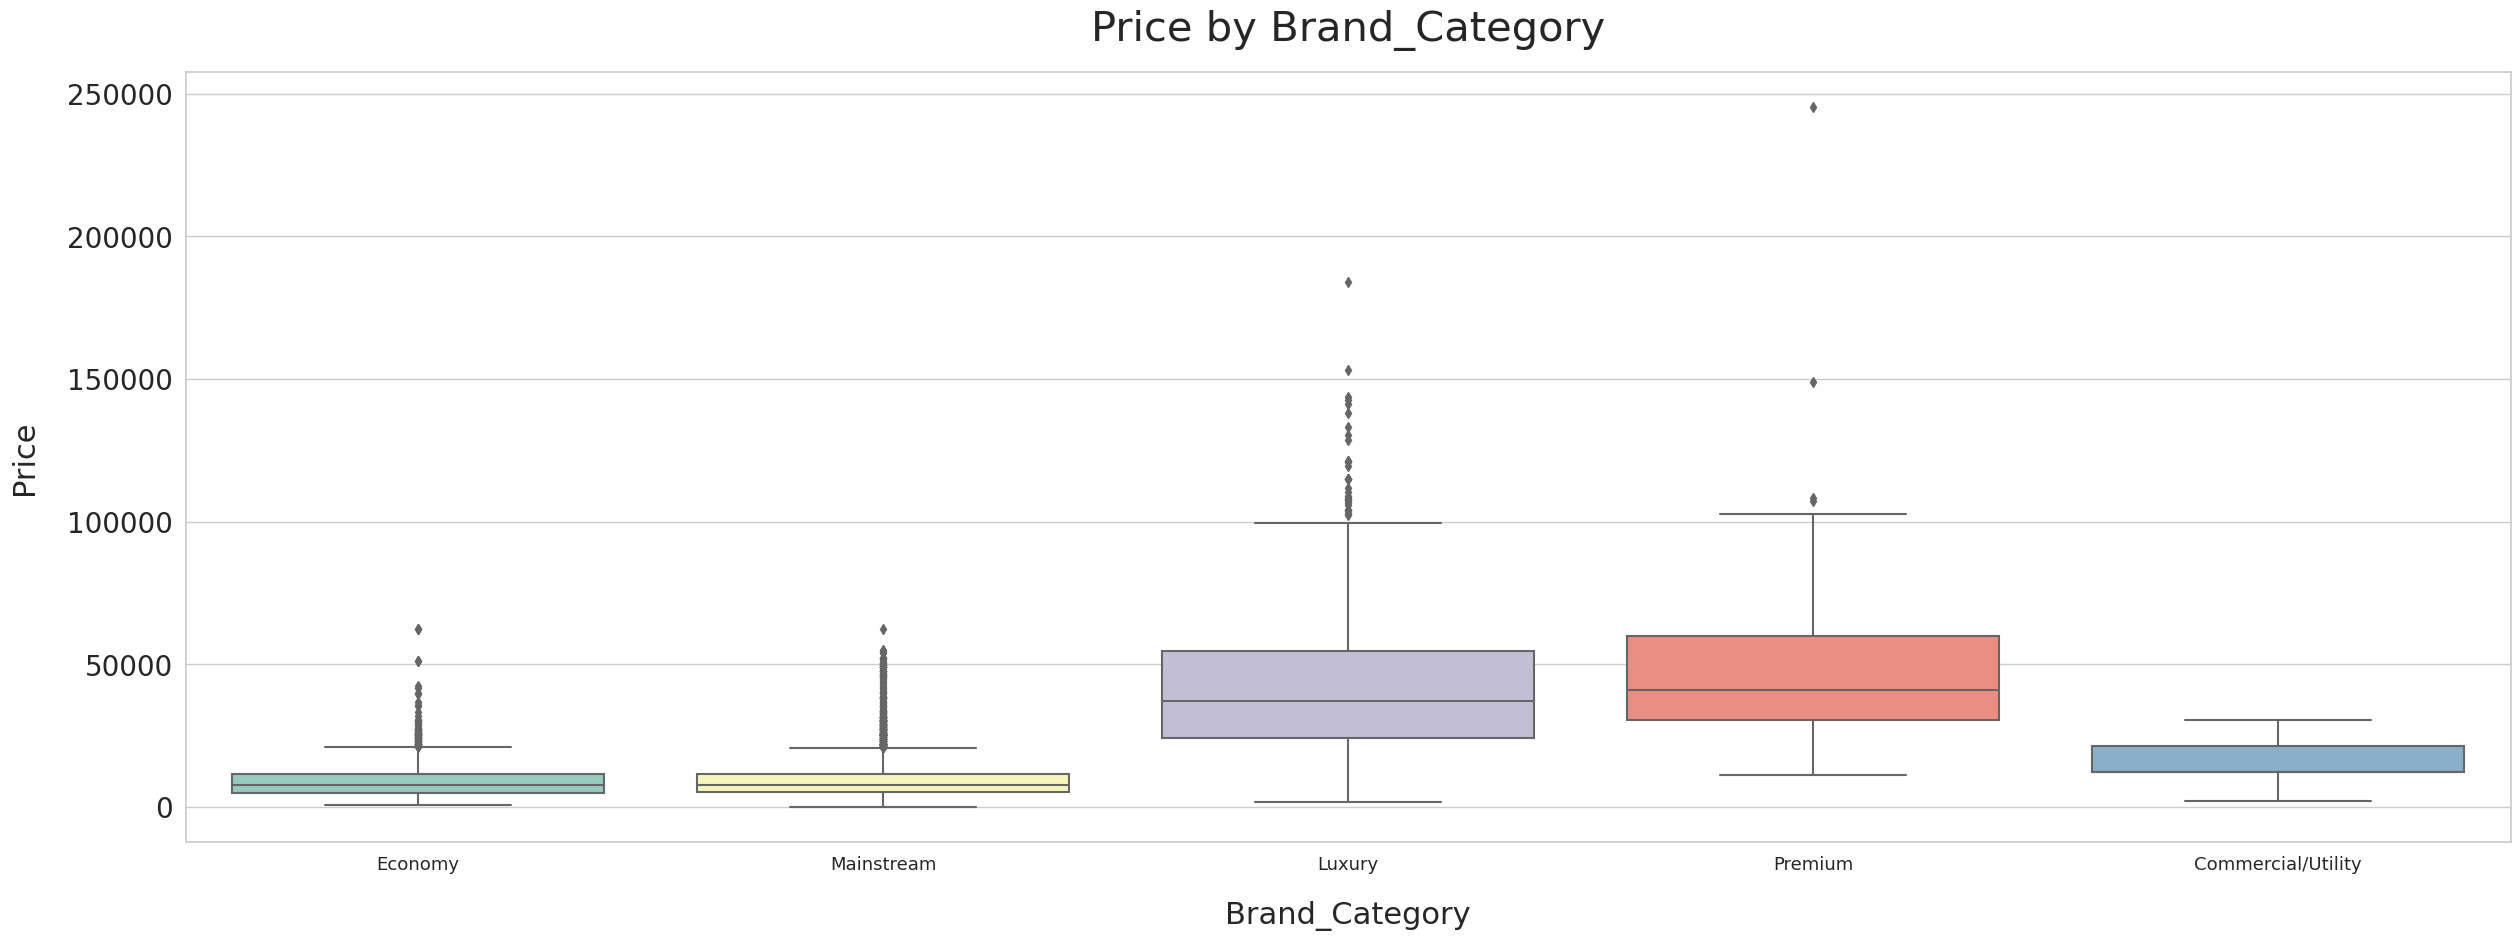

In [32]:
dummies = ["Fuel_Type", "Transmission", "Owner_Type", "Location_income", "Car_cate", "Brand_Category"]

for dum in dummies:
    plt.figure(figsize=(30,10))
    sns.set_theme(style="whitegrid")
    sns.boxplot(x=dum, y="Price", 
                data=df, palette="Set3")
    
    plt.title("Price by "+ dum, fontsize=30, y=1.03)
    
    plt.xticks(fontsize=13)
    plt.xlabel(dum, fontsize=22, labelpad=20)
    
    plt.yticks(fontsize=20)
    plt.ylabel("Price", fontsize=22, labelpad=20)
    
    plt.show()

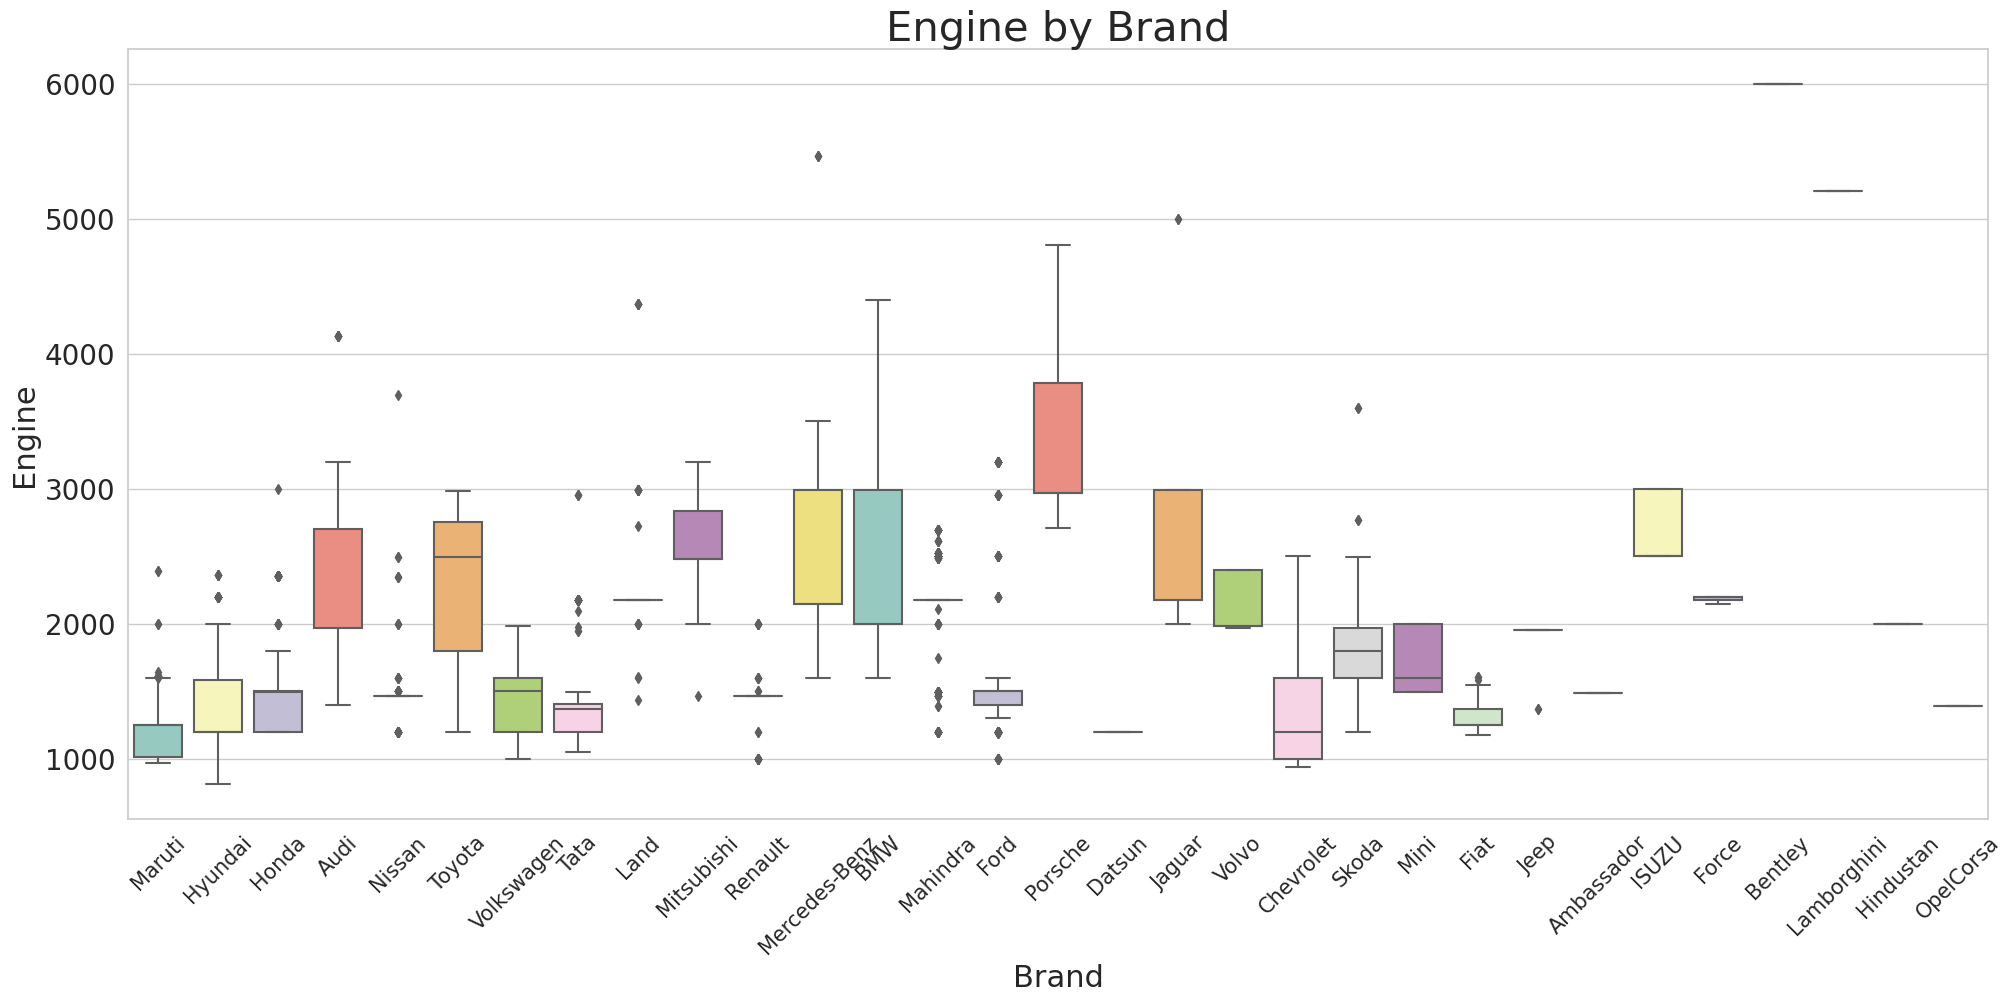

In [33]:
plt.figure(figsize=(24,10))
sns.set_theme(style="whitegrid")
sns.boxplot(x="Brand", y="Engine", data=df, palette="Set3")

plt.title("Engine by Brand", fontsize=30)
plt.xticks(fontsize=15, rotation=45)  # X-axis labels rotated by 45 degrees
plt.xlabel("Brand", fontsize=22)
plt.yticks(fontsize=20)
plt.ylabel("Engine", fontsize=22)

plt.show()

In [34]:
df.drop(labels = 'Location', axis = 1, inplace = True)
df.drop(labels = 'Name', axis = 1, inplace = True)
df.drop(labels = 'Seats', axis = 1, inplace = True)
df.drop(labels = 'Brand', axis = 1, inplace = True)

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7003 entries, 0 to 7252
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Price              5992 non-null   float64
 1   Year               7003 non-null   int64  
 2   Kilometers_Driven  7003 non-null   int64  
 3   Fuel_Type          7003 non-null   object 
 4   Transmission       7003 non-null   object 
 5   Owner_Type         7003 non-null   object 
 6   Mileage            7003 non-null   float64
 7   Engine             7003 non-null   float64
 8   Power              7003 non-null   float64
 9   Location_income    7003 non-null   object 
 10  Car_cate           7003 non-null   object 
 11  Brand_Category     7003 non-null   object 
dtypes: float64(4), int64(2), object(6)
memory usage: 969.3+ KB


In [36]:
# Price 열이 결측치인 행을 분리
df_mis_price = df[df['Price'].isna()]

# Price 열이 결측치가 아닌 행을 분리
df_nmis_price = df[df['Price'].notna()]

In [37]:
print(df_mis_price.shape)
print(df_nmis_price.shape)

(1011, 12)
(5992, 12)


In [38]:
from scipy.stats import chi2_contingency
print("열 이름 확인:\n", df.columns)

# 데이터의 처음 몇 개 행 확인
df.head(10)

열 이름 확인:
 Index(['Price', 'Year', 'Kilometers_Driven', 'Fuel_Type', 'Transmission',
       'Owner_Type', 'Mileage', 'Engine', 'Power', 'Location_income',
       'Car_cate', 'Brand_Category'],
      dtype='object')


,Price,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Location_income,Car_cate,Brand_Category
0,2682.68,14,72000,CNG,Manual,First,26.60,998.0,58.16,High,Standard Car,Economy
1,19162.00,9,41000,Diesel,Manual,First,19.67,1582.0,126.20,Median,Standard Car,Mainstream
2,6898.32,13,46000,Petrol,Manual,First,18.20,1199.0,88.70,High,Standard Car,Mainstream
3,9197.76,12,87000,Diesel,Manual,First,20.77,1248.0,88.76,High,SUV,Economy
4,27194.71,11,40670,Diesel,Automatic,Second,15.20,1968.0,140.80,Median,Standard Car,Luxury
5,3602.46,12,75000,LPG,Manual,First,21.10,814.0,55.20,Median,Standard Car,Mainstream
6,5365.36,11,86999,Diesel,Manual,First,23.08,1461.0,63.10,Low,Standard Car,Mainstream
7,26826.80,8,36000,Diesel,Automatic,First,11.36,2755.0,171.50,High,Large Vehicle,Mainstream
8,7971.39,11,64430,Diesel,Manual,First,20.54,1598.0,103.60,Median,Standard Car,Mainstream
9,2989.27,12,65932,Diesel,Manual,Second,22.30,1248.0,74.00,High,Standard Car,Economy


In [41]:
df_raw = df[['Brand_Category', 'Location_income']]
df_raw.dropna(subset=['Brand_Category', 'Location_income'], inplace=True)
df_raw

,Brand_Category,Location_income
0,Economy,High
1,Mainstream,Median
2,Mainstream,High
3,Economy,High
4,Luxury,Median
...,...,...
7248,Mainstream,Median
7249,Mainstream,High
7250,Mainstream,Median
7251,Mainstream,Median


In [43]:
#귀무가설 : Brand_Category와 Location_Income은 독립적이다.
#대립가설 : Brand_Category와 Location_Income은 독립적이지 않다.
cross_tab = pd.crosstab(df['Brand_Category'], df['Location_income'])

# 카이제곱 검정 수행
chi2_stat, p_value, dof, expected = chi2_contingency(cross_tab)

# 결과 출력
print(f"카이제곱 통계량: {chi2_stat}")
print(f"P-value(유의확률): {p_value}")
print(f"자유도: {dof}")
print("기대 빈도:\n", expected)

카이제곱 통계량: 25.886788305189196
P-value(유의확률): 0.001098184479425168
자유도: 8
기대 빈도:
 [[   3.68413537    1.72069113    4.5951735 ]
 [ 813.45708982  379.92860203 1014.61430815]
 [ 385.36055976  179.98429245  480.65514779]
 [1331.07810938  621.68570613 1660.23618449]
 [  46.42010567   21.68070827   57.89918606]]
Brand Category와 Location Income 사이에는 통계적으로 유의미한 관계가 있습니다.


#
p-value값이 0.05보다 작으므로 귀무가설을 기각한다. 즉, 특정 소득 수준(Location_income)에 따라 특정 브랜드 카테고리의 중고차 비율이 달라질 가능성이 있으며, 두 변수 사이에 통계적으로 유의미한 관계가 있다고 볼 수 있습니다.
#
이러한 결과는 소득 수준에 따라 사람들이 선호하는 중고차 브랜드가 달라질 수 있음을 시사하고, 이는 특정 소득 수준에서 특정 브랜드의 중고차가 더 많이 판매될 수 있다고 볼 수 있습니다.

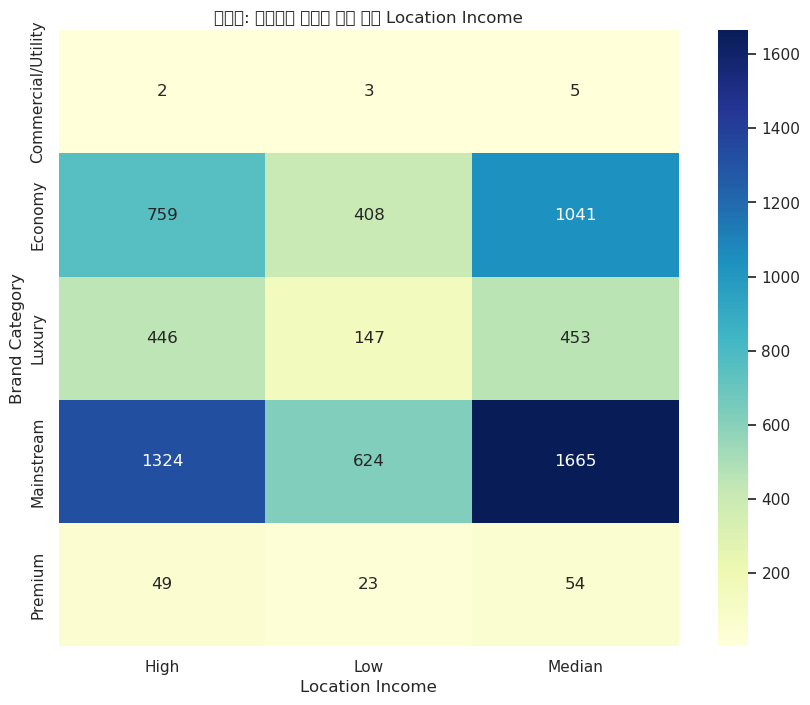

In [44]:
plt.figure(figsize=(10, 8))
sns.heatmap(cross_tab, annot=True, cmap="YlGnBu", fmt='g')  # 'g'는 정수 형식으로 숫자를 표시합니다.
plt.title('히트맵: 제조사별 중고차 비율 대비 Location Income')
plt.xlabel('Location Income')
plt.ylabel('Brand Category')
plt.show()

밝은 색상 : 특정 브랜드가 특정 소득 수준에서 드물게 나타난다는 것을 의미함.
진한 색상 : 특정 브랜드가 특정 소득 수준에서 빈번히 나타난다는 것을 의미함.